# Building a Deep Learning Model from Scratch for classification of Bird Species (131 classes)

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="sai-course-project-1")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/saik65489/sai-course-project-1


'https://jovian.ai/saik65489/sai-course-project-1'

Importing Required Modules for model

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import opendatasets as od

In [3]:
download_url = 'https://www.kaggle.com/gpiosenka/100-bird-species'

#Downloading Datsets from the link into the colab directory

In [4]:
od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saik65489
Your Kaggle Key: ········


  0%|                                                                             | 1.00M/2.83G [00:00<06:53, 7.35MB/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2.83G/2.83G [10:24<00:00, 4.86MB/s]


In [5]:
import os
len(os.listdir('./100-bird-species/birds_rev2/train'))

275

In [6]:
data_dir_train = './100-bird-species/birds_rev2/train'
data_dir_test = './100-bird-species/birds_rev2/test'

In [7]:
from torchvision.datasets import ImageFolder

Storing the Images in a Dataset variable using Torchvision's ImageFolder

In [8]:
dataset_train = ImageFolder(data_dir_train)

In [9]:
dataset_test = ImageFolder(data_dir_test)

In [10]:
dataset_train[0]

(<PIL.Image.Image image mode=RGB size=224x224 at 0x15DA04F3A60>, 0)

In [11]:
len(dataset_train)

39364

In [12]:
len(dataset_train.classes)

275

In [13]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir_train,tt.Compose([tt.Resize(64),tt.RandomCrop(64),tt.ToTensor()]))

In [14]:
test = ImageFolder(data_dir_test,tt.Compose([tt.Resize(64),tt.RandomCrop(64),tt.ToTensor()]))

In [15]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))
train_size = len(dataset) - val_size
train_size,val_size

(35428, 3936)

'AFRICAN CROWNED CRANE'

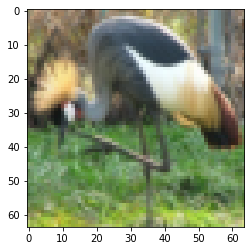

In [16]:
img,label = dataset[0]
plt.imshow(img.permute(1,2,0))
dataset_train.classes[label]

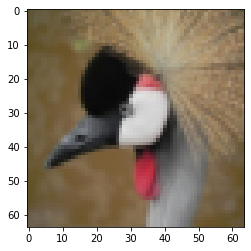

In [17]:
img,label = test[0]
plt.imshow(img.permute(1,2,0))

In [18]:
train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [19]:
len(train_ds)

35428

In [20]:
batch_size = 64
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory = True)
valid_dl = DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

In [21]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Printing a Batch of Images using show_batch function

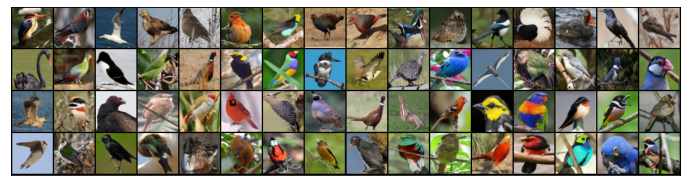

In [22]:
show_batch(train_dl)

#Creating essential Functions for using GPU for model training

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
torch.cuda.is_available()

False

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Extending nn.Module Class for knowing the losses and accuracies while training

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Defining evaluate and fit function to train the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model Buliding Step

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 64 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 64 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 64 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 64 x 128 x 32 x 32
                                  conv_block(128, 128)) # 64 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 64 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 64 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 64 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 64 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 64 x 512 x 1 x 1 
                                        nn.Flatten(), # 64 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
len(dataset.classes)

275

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
jovian.commit('sai-course-project-1.ipynb')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/saik65489/sai-course-project-1


'https://jovian.ai/saik65489/sai-course-project-1'

In [ ]:
torch.cuda.empty_cache()

In [ ]:

for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([64, 275])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.005796371027827263, 'val_loss': 5.617814540863037}]

#Model Training

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 5.0347, val_loss: 3.8626, val_acc: 0.1819
Epoch [1], train_loss: 3.1193, val_loss: 2.4313, val_acc: 0.4472
Epoch [2], train_loss: 2.0140, val_loss: 1.7384, val_acc: 0.5712
Epoch [3], train_loss: 1.4233, val_loss: 1.4335, val_acc: 0.6376
Epoch [4], train_loss: 1.0706, val_loss: 1.2055, val_acc: 0.7063


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8879, val_loss: 1.0518, val_acc: 0.7463
Epoch [1], train_loss: 0.6553, val_loss: 0.9202, val_acc: 0.7702
Epoch [2], train_loss: 0.4983, val_loss: 0.9190, val_acc: 0.7674
Epoch [3], train_loss: 0.3675, val_loss: 0.8725, val_acc: 0.7917
Epoch [4], train_loss: 0.2905, val_loss: 0.8074, val_acc: 0.8031


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2669, val_loss: 0.8660, val_acc: 0.8032
Epoch [1], train_loss: 0.1880, val_loss: 0.8627, val_acc: 0.8076
Epoch [2], train_loss: 0.1501, val_loss: 0.8072, val_acc: 0.8196
Epoch [3], train_loss: 0.1337, val_loss: 0.7740, val_acc: 0.8245
Epoch [4], train_loss: 0.1140, val_loss: 0.8814, val_acc: 0.8152


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0860, val_loss: 0.7837, val_acc: 0.8346
Epoch [1], train_loss: 0.0795, val_loss: 0.7751, val_acc: 0.8369
Epoch [2], train_loss: 0.0772, val_loss: 0.7625, val_acc: 0.8388
Epoch [3], train_loss: 0.0750, val_loss: 0.7700, val_acc: 0.8406
Epoch [4], train_loss: 0.0717, val_loss: 0.7647, val_acc: 0.8416


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

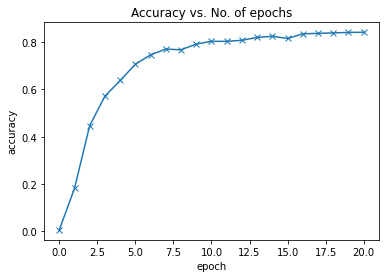

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

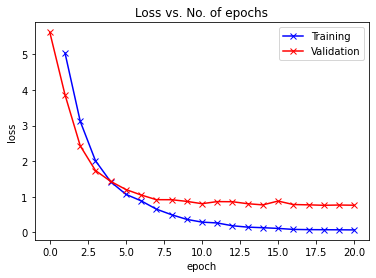

In [ ]:
plot_losses(history)

There are no signs of overfitting in the model. Still, there is a scope for improving the accuarcy of model

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=64, 
                       arch='ResNet9', 
                       epochs=[5, 5, 5, 5], 
                       lrs=[0.001, 0.001, 0.001, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


Redefining the earlier fit function to include weight decay, gradient clipping and Adaptive Learning rate

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.003780241822823882, 'val_loss': 5.618686676025391}]

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 4.9295, val_loss: 5.1319, val_acc: 0.0970
Epoch [1], train_loss: 3.3183, val_loss: 2.8683, val_acc: 0.3608
Epoch [2], train_loss: 2.2719, val_loss: 4.0062, val_acc: 0.2876
Epoch [3], train_loss: 1.8199, val_loss: 2.5729, val_acc: 0.4144
Epoch [4], train_loss: 1.5722, val_loss: 2.0541, val_acc: 0.5262
Epoch [5], train_loss: 1.4072, val_loss: 1.8404, val_acc: 0.5609
Epoch [6], train_loss: 1.2571, val_loss: 1.9294, val_acc: 0.5544
Epoch [7], train_loss: 1.1148, val_loss: 1.4568, val_acc: 0.6565
Epoch [8], train_loss: 0.9450, val_loss: 1.1788, val_acc: 0.7151
Epoch [9], train_loss: 0.7633, val_loss: 0.9387, val_acc: 0.7750
Epoch [10], train_loss: 0.5792, val_loss: 0.7707, val_acc: 0.8056
Epoch [11], train_loss: 0.3802, val_loss: 0.6436, val_acc: 0.8422
Epoch [12], train_loss: 0.2088, val_loss: 0.5818, val_acc: 0.8569
Epoch [13], train_loss: 0.1118, val_loss: 0.5361, val_acc: 0.8760
Epoch [14], train_loss: 0.0760, val_loss: 0.5333, val_acc: 0.8762
CPU times: user 5min

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

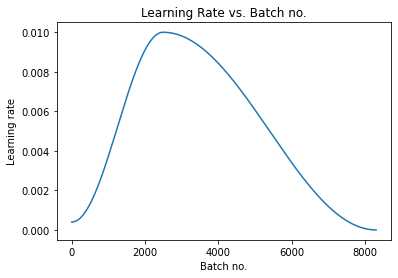

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset_train.classes[preds[0].item()]

Label: HORNED GUAN , Predicted: HORNED GUAN


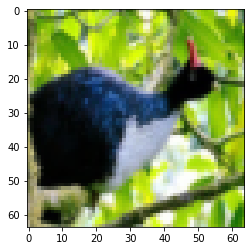

In [ ]:
img, label = val_ds[1002]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset_train.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9639653563499451, 'val_loss': 0.13083572685718536}

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'max_lr': max_lr,
})

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


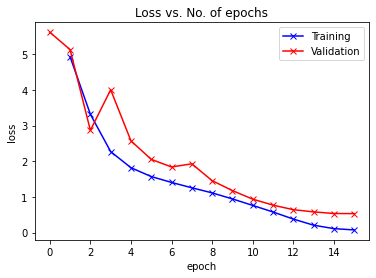

In [ ]:
plot_losses(history)

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [ ]:
torch.save(model.state_dict(), 'birds-137')

Label: RAINBOW LORIKEET , Predicted: RAINBOW LORIKEET


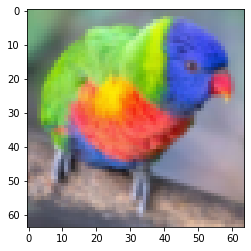

In [ ]:
img, label = test[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
print('Final Test Accuracy Achieved is {:.2f} %'.format(result['val_acc']*100))

Final Test Accuracy Achieved is 96.40 %


Final Accuracy of the test dataset obtained is 96.4%, which is very good for this dataset containing over 100 classes. We can also train the model with a deeper network, or using transfer learning approach for better results on the validation 

In [115]:
!pip install jovian --upgrade -q
import jovian